In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=769f5c543daaf28f118e61f860f0303757c3efd4621d017ae35fcbd15e631406
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


Số lượng mẫu huấn luyện: 1548
Số lượng mẫu kiểm tra: 388
Ngày cuối cùng trong toàn bộ dataset: 2025-05-10
Giá đóng cửa cuối cùng trong dataset: 104696.33

Bắt đầu tìm kiếm tham số tối ưu cho SVR (có thể mất vài phút)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Tham số SVR tốt nhất: {'C': 100, 'epsilon': 0.01, 'gamma': 0.01}

----- Đánh giá mô hình trên tập KIỂM TRA -----
RMSE: 2953.38
MAE: 2181.18
R² Score: 0.9654
MAPE: 2.63%

----- Dự đoán cho ngày tiếp theo -----
Ngày cuối cùng trong dataset: 2025-05-10, Giá: 104696.33
Dự đoán giá cho ngày 2025-05-11: 99380.33 USD

----- Dự đoán cho ngày bất kỳ trong tương lai -----
Nhập ngày bạn muốn dự đoán (YYYY-MM-DD), hoặc gõ 'exit' để thoát: 2025-06-03

Dự đoán cho 24 ngày tới, đến 2025-06-03...
CẢNH BÁO: Dự đoán càng xa, độ tin cậy càng giảm do lỗi tích lũy.

--- Kết quả cho ngày 2025-06-03 ---
Giá dự đoán cho ngày 2025-06-03: **77122.24 USD**

Dự đoán cho các ngày gần nhất (bao gồm ngày mục tiêu):
  Ngày: 2025-05-30, Giá d

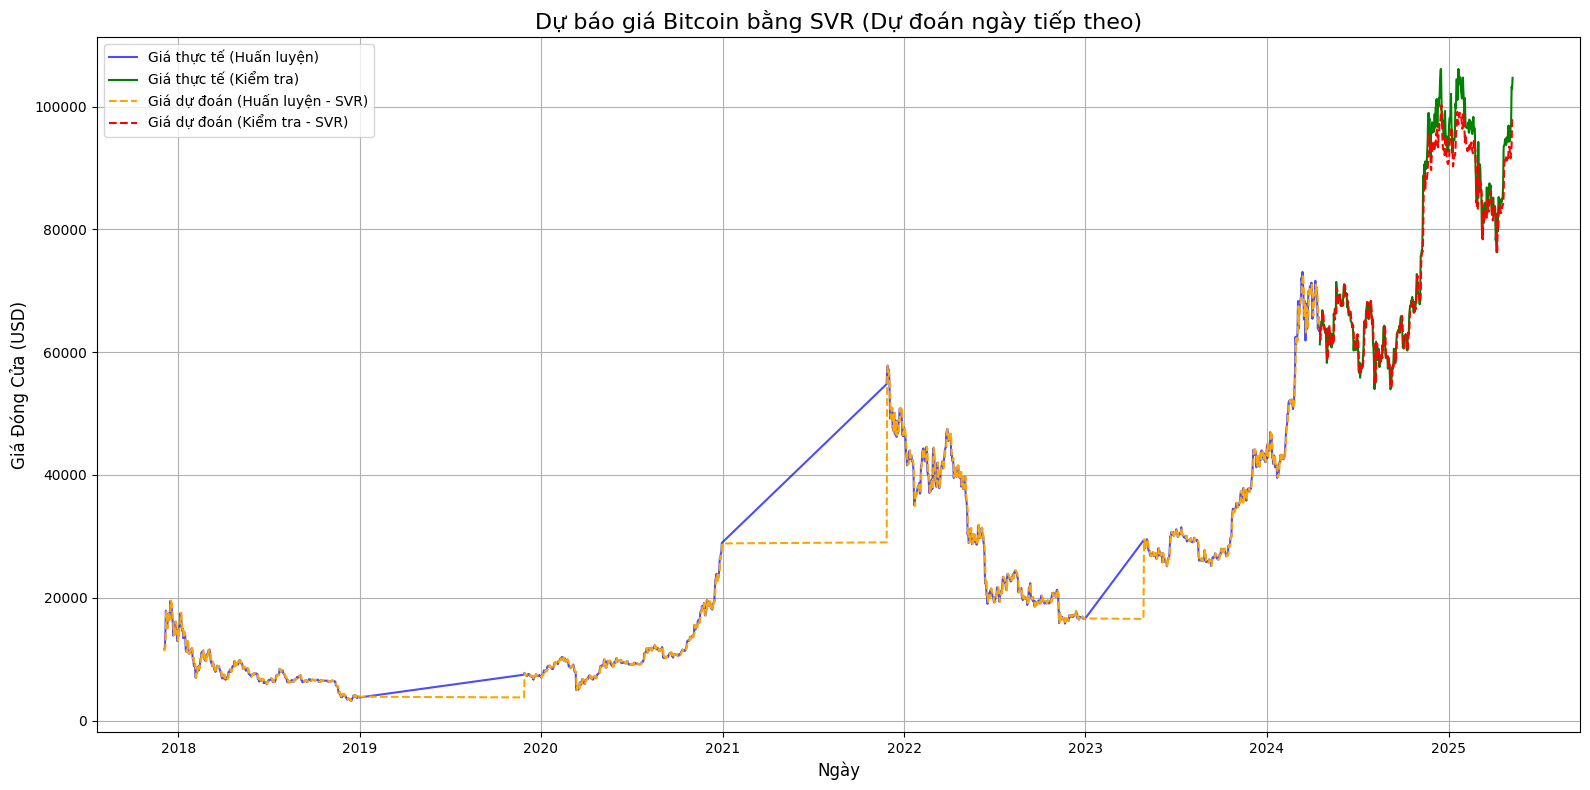


Hoàn thành.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import timedelta # Để làm việc với ngày tháng

# --- CÀI ĐẶT CHO HIỂN THỊ TIẾNG VIỆT TRÊN BIỂU ĐỒ (TÙY CHỌN) ---
# plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['axes.unicode_minus'] = False

# Hàm tính MAPE
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not np.all(mask):
        print("Cảnh báo: Có giá trị 0 trong y_true. Các điểm này sẽ được bỏ qua khi tính MAPE.")
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# 1. Đọc và chuẩn bị dữ liệu
try:
    df = pd.read_csv('/content/Bitcoin.csv',delimiter=';') # Đảm bảo đường dẫn file đúng
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file coin_Bitcoin.csv. Vui lòng đảm bảo file nằm trong cùng thư mục.")
    exit()

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
data_for_model = df[['Date', 'Close']].copy()
data_for_model.set_index('Date', inplace=True)
close_prices = data_for_model['Close'].values

# 2. Tạo đặc trưng chuỗi thời gian
def create_lag_features(series, n_lags):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

n_lags = 7
X, y = create_lag_features(close_prices, n_lags)
dates_for_y = data_for_model.index[n_lags:]

# 3. Chuẩn hóa dữ liệu
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# 4. Chia tập train/test
split_ratio = 0.8
split_index = int(len(X_scaled) * split_ratio)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]
dates_train = dates_for_y[:split_index]
dates_test = dates_for_y[split_index:]

print(f"Số lượng mẫu huấn luyện: {len(X_train)}")
print(f"Số lượng mẫu kiểm tra: {len(X_test)}")
print(f"Ngày cuối cùng trong toàn bộ dataset: {data_for_model.index[-1].strftime('%Y-%m-%d')}")
print(f"Giá đóng cửa cuối cùng trong dataset: {close_prices[-1]:.2f}")

# 5. Huấn luyện mô hình SVR
# Để tiết kiệm thời gian, bạn có thể dùng tham số cố định thay vì GridSearchCV
# Ví dụ: best_model = SVR(C=100, gamma='scale', epsilon=0.01)
#        best_model.fit(X_train, y_train)
# Hoặc chạy GridSearchCV:
tscv = TimeSeriesSplit(n_splits=3) # Giảm n_splits để chạy nhanh hơn
param_grid = {
    'C': [100, 500],             # Giảm số lượng tham số
    'gamma': ['scale', 0.01],
    'epsilon': [0.05, 0.01]
}
print("\nBắt đầu tìm kiếm tham số tối ưu cho SVR (có thể mất vài phút)...")
grid_search = GridSearchCV(SVR(), param_grid, cv=tscv,
                           scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"\nTham số SVR tốt nhất: {grid_search.best_params_}")


# 6. Dự báo trên tập train và test (để vẽ đồ thị)
y_pred_train_scaled = best_model.predict(X_train)
y_pred_train_orig = scaler_y.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).ravel()
y_pred_test_scaled = best_model.predict(X_test)
y_pred_test_orig = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).ravel()
y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

# 7. Đánh giá mô hình trên tập kiểm tra
print("\n----- Đánh giá mô hình trên tập KIỂM TRA -----")
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_orig))
mae = mean_absolute_error(y_test_orig, y_pred_test_orig)
r2 = r2_score(y_test_orig, y_pred_test_orig)
mape = calculate_mape(y_test_orig, y_pred_test_orig)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


# --- PHẦN MỚI: DỰ ĐOÁN CHO NGÀY TIẾP THEO VÀ NGÀY BẤT KỲ ---

# 9. Dự đoán giá cho ngày tiếp theo sau ngày cuối cùng trong dataset
last_date_in_dataset = data_for_model.index[-1]
next_day_date = last_date_in_dataset + timedelta(days=1)
last_n_lags_prices = close_prices[-n_lags:]
last_n_lags_prices_scaled = scaler_X.transform(last_n_lags_prices.reshape(1, -1))
next_day_pred_scaled = best_model.predict(last_n_lags_prices_scaled)
next_day_pred_orig = scaler_y.inverse_transform(next_day_pred_scaled.reshape(-1, 1)).ravel()[0]
print(f"\n----- Dự đoán cho ngày tiếp theo -----")
print(f"Ngày cuối cùng trong dataset: {last_date_in_dataset.strftime('%Y-%m-%d')}, Giá: {close_prices[-1]:.2f}")
print(f"Dự đoán giá cho ngày {next_day_date.strftime('%Y-%m-%d')}: {next_day_pred_orig:.2f} USD")


# 10. Hàm dự đoán cho một ngày bất kỳ trong tương lai
def predict_future_date(target_date_str, current_prices_sequence, last_known_date, model, scaler_x, scaler_y_local, num_lags):
    try:
        target_date = pd.to_datetime(target_date_str)
    except ValueError:
        print("Lỗi: Định dạng ngày không hợp lệ. Vui lòng sử dụng 'YYYY-MM-DD'.")
        return None, [] # (predicted_value, history_list)

    # Trường hợp 1: Ngày mục tiêu là ngày đã có trong dữ liệu
    if target_date <= last_known_date:
        print(f"Thông báo: Ngày mục tiêu ({target_date_str}) không ở tương lai so với dữ liệu đã biết cuối cùng ({last_known_date.strftime('%Y-%m-%d')}).")
        if target_date in data_for_model.index:
             actual_price = data_for_model.loc[target_date, 'Close']
             print(f"Giá thực tế cho {target_date_str} (đã có trong dataset): {actual_price:.2f} USD")
             return actual_price, [(target_date, actual_price)] # Trả về giá thực tế và lịch sử chỉ chứa điểm đó
        else:
            print(f"Không có dữ liệu thực tế cho {target_date_str} (ví dụ: ngày nghỉ) và ngày này không ở tương lai để dự đoán mới.")
            return None, []

    # Trường hợp 2: Ngày mục tiêu ở tương lai, cần dự đoán
    num_days_to_predict = (target_date - last_known_date).days
    print(f"\nDự đoán cho {num_days_to_predict} ngày tới, đến {target_date_str}...")
    print("CẢNH BÁO: Dự đoán càng xa, độ tin cậy càng giảm do lỗi tích lũy.")

    temp_prices = list(current_prices_sequence)
    predictions_history = [] # (date, predicted_price)

    current_date_iter = last_known_date
    for _ in range(num_days_to_predict): # Lặp số ngày cần dự đoán
        input_features = np.array(temp_prices[-num_lags:]).reshape(1, -1)
        input_features_scaled = scaler_x.transform(input_features)
        predicted_scaled_price = model.predict(input_features_scaled)
        predicted_price_orig = scaler_y_local.inverse_transform(predicted_scaled_price.reshape(-1, 1)).ravel()[0]
        temp_prices.append(predicted_price_orig) # Thêm giá dự đoán vào chuỗi để dùng cho lần lặp sau
        current_date_iter += timedelta(days=1)
        predictions_history.append((current_date_iter, predicted_price_orig))

    final_predicted_price_for_target_date = predictions_history[-1][1] # Giá của ngày cuối cùng trong lịch sử dự đoán
    return final_predicted_price_for_target_date, predictions_history


# Sử dụng hàm để dự đoán
print("\n----- Dự đoán cho ngày bất kỳ trong tương lai -----")
initial_sequence_for_future = close_prices # Dùng toàn bộ chuỗi giá thực tế làm cơ sở ban đầu
last_date_for_future_pred = data_for_model.index[-1] # Ngày cuối cùng có dữ liệu thực tế

while True:
    user_date_input = input("Nhập ngày bạn muốn dự đoán (YYYY-MM-DD), hoặc gõ 'exit' để thoát: ")
    if user_date_input.lower() == 'exit':
        break

    target_date_obj = None
    try:
        target_date_obj = pd.to_datetime(user_date_input)
    except ValueError:
        print("Lỗi: Định dạng ngày không hợp lệ. Vui lòng sử dụng 'YYYY-MM-DD'.")
        continue

    # Gọi hàm dự đoán
    value_for_target_date, history_predictions = predict_future_date(
        user_date_input,
        initial_sequence_for_future,
        last_date_for_future_pred,
        best_model,
        scaler_X,
        scaler_y,
        n_lags
    )

    # Xử lý và hiển thị kết quả
    if value_for_target_date is not None:
        print(f"\n--- Kết quả cho ngày {user_date_input} ---")

        is_future_prediction = True # Mặc định là dự đoán tương lai
        if target_date_obj <= last_date_for_future_pred and target_date_obj in data_for_model.index:
            # Kiểm tra xem history_predictions có phải chỉ là điểm dữ liệu thực tế không
            if len(history_predictions) == 1 and history_predictions[0][0] == target_date_obj:
                 # np.isclose để so sánh float một cách an toàn
                if np.isclose(history_predictions[0][1], data_for_model.loc[target_date_obj, 'Close']):
                    is_future_prediction = False

        if not is_future_prediction:
            # Đây là dữ liệu thực tế từ dataset
            actual_price_from_dataset = data_for_model.loc[target_date_obj, 'Close'] # Lấy lại cho chắc
            print(f"Giá thực tế cho ngày {target_date_obj.strftime('%Y-%m-%d')}: **{actual_price_from_dataset:.2f} USD** (Dữ liệu từ dataset)")

            num_recent_days_to_show = 5
            # Lấy các ngày thực tế <= ngày mục tiêu, tối đa 5 ngày
            relevant_actual_data_df = data_for_model[data_for_model.index <= target_date_obj].tail(num_recent_days_to_show)

            if not relevant_actual_data_df.empty:
                print("\nDữ liệu thực tế gần nhất (bao gồm ngày mục tiêu):")
                for date_act, row_act in relevant_actual_data_df.iterrows():
                    print(f"  Ngày: {date_act.strftime('%Y-%m-%d')}, Giá thực tế: {row_act['Close']:.2f} USD")

        else: # Đây là trường hợp dự đoán cho tương lai
            print(f"Giá dự đoán cho ngày {target_date_obj.strftime('%Y-%m-%d')}: **{value_for_target_date:.2f} USD**")

            num_recent_days_to_show = 5
            # history_predictions chứa các dự đoán từ ngày sau last_date_for_future_pred đến target_date_obj
            # Lấy tối đa num_recent_days_to_show mục cuối cùng từ history_predictions
            start_index_hist = max(0, len(history_predictions) - num_recent_days_to_show)
            recent_predictions_to_display = history_predictions[start_index_hist:]

            if recent_predictions_to_display:
                print("\nDự đoán cho các ngày gần nhất (bao gồm ngày mục tiêu):")
                for date_hist, price_hist in recent_predictions_to_display:
                    print(f"  Ngày: {date_hist.strftime('%Y-%m-%d')}, Giá dự đoán: {price_hist:.2f} USD")
            # else: # history_predictions rỗng, không nên xảy ra nếu is_future_prediction là True và value_for_target_date is not None
    # else: # value_for_target_date is None
        # Hàm predict_future_date đã in lỗi (ví dụ: ngày không hợp lệ, hoặc ngày quá khứ không có trong data)
        pass

#8. Vẽ biểu đồ kết quả (Tùy chọn hiển thị)
plt.figure(figsize=(16, 8))
plt.plot(dates_train, y_train_orig, label='Giá thực tế (Huấn luyện)', color='blue', alpha=0.7)
plt.plot(dates_test, y_test_orig, label='Giá thực tế (Kiểm tra)', color='green')
plt.plot(dates_train, y_pred_train_orig, label='Giá dự đoán (Huấn luyện - SVR)', color='orange', linestyle='--')
plt.plot(dates_test, y_pred_test_orig, label='Giá dự đoán (Kiểm tra - SVR)', color='red', linestyle='--')
plt.title("Dự báo giá Bitcoin bằng SVR (Dự đoán ngày tiếp theo)", fontsize=16)
plt.xlabel("Ngày", fontsize=12)
plt.ylabel("Giá Đóng Cửa (USD)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("bitcoin_svr_prediction_full.png")
print("\nĐã lưu biểu đồ bitcoin_svr_prediction_full.png")
plt.show()
print("\nHoàn thành.")